In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [1]:
!pip install -U controlnet-aux

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 6.2 MB/s eta 0:00:00


In [2]:
import random

import requests
import torch
from controlnet_aux import ZoeDetector
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

/usr/local/lib/python3.12/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)
/usr/local/lib/python3.12/dist-packages/controlnet_aux/segment_anything/modeling/tiny_vit_sam.py:654: UserWarning: Overwriting tiny_vit_5m_224 in registry with controlnet_aux.segmen

In [4]:
from diffusers import (
    AutoencoderKL,
    ControlNetModel,
    StableDiffusionXLControlNetPipeline,
    StableDiffusionXLInpaintPipeline,
)

In [5]:
def scale_and_paste(original_image):
    aspect_ratio = original_image.width / original_image.height

    if original_image.width > original_image.height:
        new_width = 1024
        new_height = round(new_width / aspect_ratio)
    else:
        new_height = 1024
        new_width = round(new_height * aspect_ratio)

    # make the subject a little smaller
    new_width = new_width - 20
    new_height = new_height - 20

    resized_original = original_image.resize((new_width, new_height), Image.LANCZOS)
    white_background = Image.new("RGBA", (1024, 1024), "white")
    x = (1024 - new_width) // 2
    y = (1024 - new_height) // 2
    white_background.paste(resized_original, (x, y), resized_original)

    return resized_original, white_background

In [6]:
img_path = "/content/drive/MyDrive/Outpainting/datasets/crop/image_00577.png"

original_image = Image.open(img_path).convert("RGBA")
resized_img, white_bg_image = scale_and_paste(original_image)

In [7]:
zoe = ZoeDetector.from_pretrained("lllyasviel/Annotators")
image_zoe = zoe(white_bg_image, detect_resolution=512, image_resolution=1024)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


ZoeD_M12_N.pt:   0%|          | 0.00/1.44G [00:00<?, ?B/s]

In [8]:
controlnets = [
    ControlNetModel.from_pretrained(
        "destitech/controlnet-inpaint-dreamer-sdxl", torch_dtype=torch.float16, variant="fp16"
    ),
    ControlNetModel.from_pretrained("diffusers/controlnet-zoe-depth-sdxl-1.0", torch_dtype=torch.float16),
]

config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/2.50G [00:00<?, ?B/s]

In [9]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

In [10]:
pipeline = StableDiffusionXLControlNetPipeline.from_pretrained(
    "SG161222/RealVisXL_V4.0", torch_dtype=torch.float16, variant="fp16", controlnet=controlnets, vae=vae
).to("cuda")

model_index.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

merges.txt: 0.00B [00:00, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


In [11]:
def generate_image(prompt, negative_prompt, inpaint_image, zoe_image, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=[inpaint_image, zoe_image],
        guidance_scale=6.5,
        num_inference_steps=25,
        generator=generator,
        controlnet_conditioning_scale=[0.5, 0.8],
        control_guidance_end=[0.9, 0.6],
    ).images[0]

    return image

In [12]:
prompt = "attach the license plate to any car"
negative_prompt = ""

temp_image = generate_image(prompt, negative_prompt, white_bg_image, image_zoe, 4138619029)

  0%|          | 0/25 [00:00<?, ?it/s]

In [13]:
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
temp_image.paste(resized_img, (x, y), resized_img)

In [14]:
mask_path = "/content/drive/MyDrive/Outpainting/datasets/masks/image_00577.png"
mask = Image.open(mask_path).convert("L")
mask = mask.resize(temp_image.size)
final_mask = mask.point(lambda p: p > 128 and 255)

In [15]:
pipeline = None
torch.cuda.empty_cache()

In [16]:
pipeline = StableDiffusionXLInpaintPipeline.from_pretrained(
    "OzzyGT/RealVisXL_V4.0_inpainting",
    torch_dtype=torch.float16,
    variant="fp16",
    vae=vae,
).to("cuda")

model_index.json:   0%|          | 0.00/721 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/588 [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/705 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

scheduler_config.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/462 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/856 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [17]:
mask_blurred = pipeline.mask_processor.blur(final_mask, blur_factor=20)

In [18]:
def generate_outpaint(prompt, negative_prompt, image, mask, seed: int = None):
    if seed is None:
        seed = random.randint(0, 2**32 - 1)

    generator = torch.Generator(device="cpu").manual_seed(seed)

    image = pipeline(
        prompt,
        negative_prompt=negative_prompt,
        image=image,
        mask_image=mask,
        guidance_scale=10.0,
        strength=0.8,
        num_inference_steps=30,
        generator=generator,
    ).images[0]

    return image

In [19]:
prompt = "high quality photo of attach the license plate to suv car"
negative_prompt = ""

In [20]:
final_image = generate_outpaint(prompt, negative_prompt, temp_image, mask_blurred, 3352253467)

  0%|          | 0/24 [00:00<?, ?it/s]

In [21]:
x = (1024 - resized_img.width) // 2
y = (1024 - resized_img.height) // 2
final_image.paste(resized_img, (x, y), resized_img)
final_image.save("result.png")

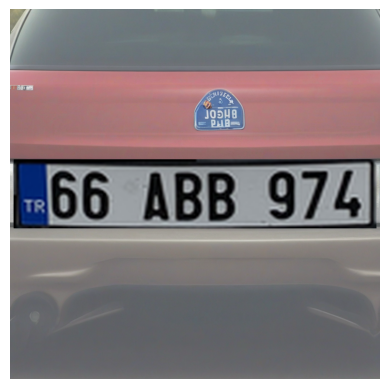

In [23]:
img = Image.open("/content/result.png")
plt.imshow(img)
plt.axis('off')
plt.show()